# 6. Credit Risk Prediction

This notebook contains lesson content completed for module 6 of the machine learning zoomcamp.

This is a binary classification problem where customers either default (1) or not (0). 

We will be using this dataset to learn about how decision trees and other ensemble models work and how to tune such models.

Dataset: [Credit Scoring Dataset](https://github.com/gastonstat/CreditScoring)

In [1]:
# Main Imports
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data Cleaning and preparation



In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

--2025-11-01 10:19:39--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.009s  

2025-11-01 10:19:39 (19.5 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [4]:
df = pd.read_csv("./assets/CreditScoring.csv")

In [5]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
status_values = {1: 'ok', 2: 'default', 0: 'unk'}

df.status = df.status.map(status_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


### Missing values

In this dataset we are aware that missing values have been replaced with 99999999, so we need to replace them with NaNs.

There is also one unknown value in the target column so we will handle this by removing that row.

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [16]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [17]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [18]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [24]:
df[df.status != 'unk'].reset_index(drop=True)


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


### Train test split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [28]:
df_full_train.reset_index(drop=True)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,6,other,30,22,single,no,fixed,35,73.0,0.0,0.0,1086,1086
1,ok,45,owner,30,64,married,no,freelance,45,157.0,20000.0,0.0,1000,1588
2,ok,2,owner,60,30,married,yes,fixed,45,174.0,4000.0,0.0,2000,2250
3,ok,11,rent,60,28,married,no,fixed,59,144.0,0.0,0.0,1225,1360
4,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3560,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3561,default,24,other,60,41,married,yes,freelance,75,0.0,0.0,0.0,2200,2428
3562,default,2,rent,48,56,single,no,freelance,51,157.0,11000.0,4500.0,1000,2008


In [29]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [31]:
del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decision Trees 

Here is an example of a decision tree we can create as a function of if and else statements:
![Decision Tree Example](./assets/dt_example.png)

In [38]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'
        


In [39]:
xi = df_train.iloc[0].to_dict()

In [40]:
assess_risk(xi)

'ok'

Now we have an understanding of the basics of how decision trees work, we can implement one using scikit learn

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [41]:
# First we need to create dictionaries for the feature matrix
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [44]:
# Then vectorise those dictionaries (equivalent to one hot encoding)
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [45]:
#Instantiate the decisiontree classifier and train it
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Testing on validation data

In [46]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [49]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [52]:
roc_auc_score(y_val, y_pred)

0.6644797834336642

This isn't a very good roc auc score. Let's see  what it was for the training set.

In [53]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

The auc is perfect at  1.0. This tells us that the model has overfit to the training data, which is why it does not predict well on the validation data in comparison to the training set.

Depth of the tree impacts the ability of the model to generalise. If we don't restrict the model will go as deep as it needs to to learn the patterns of the data, and so when presented with new data, it will struggle to predict.

Lets now retrain the model with a max depth of 3.

In [54]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [56]:
roc_auc_score(y_val, y_pred)

0.763427236430611

Still not the best but a much better performance on validation data.

In [66]:
from sklearn.tree import export_text, plot_tree

In [59]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- income <= 50.50
|   |   |   |--- class: 1
|   |   |--- income >  50.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 99.50
|   |   |   |--- class: 1
|   |   |--- income >  99.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 73.50
|   |   |   |--- class: 0
|   |   |--- income >  73.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- time <= 27.00
|   |   |   |--- class: 0
|   |   |--- time >  27.00
|   |   |   |--- class: 1



[Text(0.5, 0.875, 'records=no <= 0.5\ngini = 0.397\nsamples = 2673\nvalue = [1942.0, 731.0]'),
 Text(0.25, 0.625, 'seniority <= 6.5\ngini = 0.49\nsamples = 457\nvalue = [197, 260]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'income <= 50.5\ngini = 0.423\nsamples = 263\nvalue = [80, 183]'),
 Text(0.0625, 0.125, 'gini = 0.194\nsamples = 55\nvalue = [6, 49]'),
 Text(0.1875, 0.125, 'gini = 0.458\nsamples = 208\nvalue = [74, 134]'),
 Text(0.375, 0.375, 'income <= 99.5\ngini = 0.479\nsamples = 194\nvalue = [117, 77]'),
 Text(0.3125, 0.125, 'gini = 0.452\nsamples = 55\nvalue = [19, 36]'),
 Text(0.4375, 0.125, 'gini = 0.416\nsamples = 139\nvalue = [98.0, 41.0]'),
 Text(0.75, 0.625, 'job=partime <= 0.5\ngini = 0.335\nsamples = 2216\nvalue = [1745, 471]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'income <= 73.5\ngini = 0.284\nsamples = 1993\nvalue = [1651, 342]'),
 Text(0.5625, 0.125, 'gini = 0.474\nsamples = 373\nvalue = [229, 144]'),
 Text(0.6875, 0.125, 'gini = 0.215\nsamp

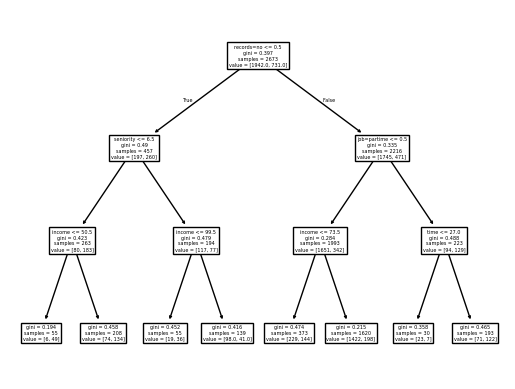

In [67]:
plot_tree(dt,feature_names=dv.get_feature_names_out(), )

## 6.4 Decision Tree Learning Algorithm